<a href="https://colab.research.google.com/github/Adabot123/NN/blob/main/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [76]:
words = open('names.txt', 'r').read().splitlines()
print(words[:6])
print(len(words))
print(max(len(w) for w in words))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte']
32033
15


In [77]:
#building the vocabulary
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i : s for s, i in stoi.items()}
print(itos)
vocab_size = len(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [78]:
import random
random.seed(42)
random.shuffle(words)

In [79]:
#building the dataset
block_size = 3

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size

    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X,Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [80]:
for x, y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

... --> y
..y --> u
.yu --> h
yuh --> e
uhe --> n
hen --> g
eng --> .
... --> d
..d --> i
.di --> o
dio --> n
ion --> d
ond --> r
ndr --> e
dre --> .
... --> x
..x --> a
.xa --> v
xav --> i
avi --> e


In [81]:
#layers
class Linear:

  def __init__(self, fan_in, fan_out, bias = True):
    self.weight = torch.randn((fan_in, fan_out))/fan_in**0.5 #kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

  def __init__(self, dim, eps = 1e-5, momentum = 0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    #parameters (trained with backdrop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    #buffers
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    if self.training:
      xmean = x.mean(0, keepdim = True) #batch mean
      xvar = x.var(0, keepdim = True)

    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return[]

class Flatten:
  def __call__(self,x):
    self.out = x.view(x.shape[0], -1)
    return self.out

  def parameters(self):
    return []

class Sequential:

  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [82]:
torch.manual_seed(42);

In [83]:
n_embd = 10 #dimensionality of the character embedding vectors
n_hidden = 200 #the number of neurons in the hidden layer of the MLP

C = torch.randn((vocab_size, n_embd))
model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])
#parameter init
with torch.no_grad():
  layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) #numbers of parameters in total
for p in parameters:
  p.requires_grad = True

11827


In [86]:
max_steps = 50000
batch_size = 32
lossi = []

for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] #batch X,Y

  #forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) #loss function

  #backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  #update SGD
  lr = 0.1 if i < 150000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  #track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/2.4702
  10000/2.2248
  20000/2.1183
  30000/2.2429
  40000/1.9195


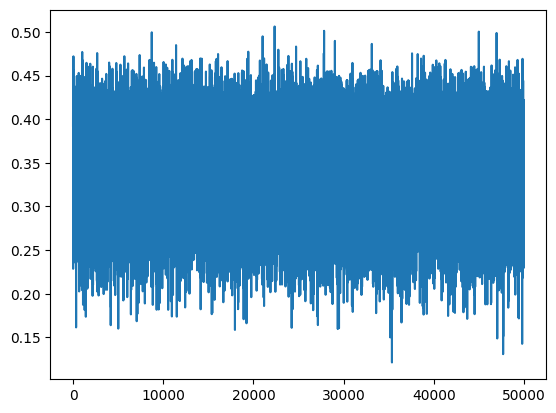

In [87]:
plt.plot(lossi)

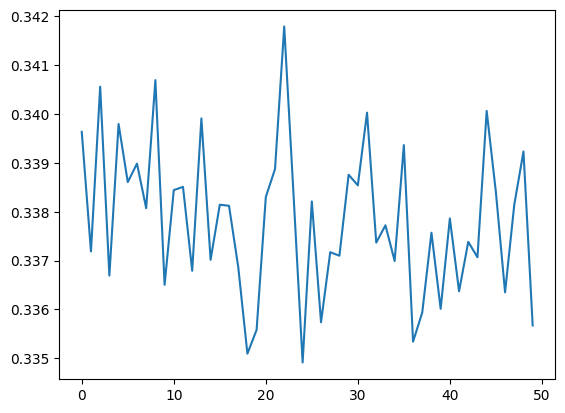

In [88]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [89]:
for layer in model.layers:
  layer.training = False

In [90]:
#evaluate the loss
@torch.no_grad()
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'val':(Xdev, Ydev),
      'test': (Xte, Yte),
      }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())
split_loss('train')
split_loss('val')


train 2.1556737422943115
val 2.1885273456573486


In [92]:
#sample from the model

for _ in range(20):
  out = []
  context = [0] * block_size
  while True:
    logits = model(torch.tensor([context]))
    probs = F.softmax(logits, dim=1)
    #sample from the distribution
    ix = torch.multinomial(probs, num_samples=1).item()
    #shift the context window and track the samples
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))

maigairi.
malie.
kamontaen.
jalyni.
keigh.
zah.
kara.
daylie.
savai.
tori.
aralen.
xann.
xior.
graynah.
cone.
mayzie.
tor.
yon.
asvi.
aira.
